In [1]:
import os
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

import statsmodels.api as sm

sns.set()
pd.set_option('display.max_columns', None)

In [2]:
# Load the csv dataset into pandas dataframes
data_file = os.path.join(os.getcwd(), 'dataset', 'hr_employee_attrition.csv')
hr_df = pd.read_csv(data_file)

All rows have values for each column. Therefore, there's no need to drop any rows.

Upon inspection, column ```Over18``` has values that are all 'Y'. A good assumption would be that a person has to be 18 years old at the minimum to be employed. Initially, this can be considered uselss. However, I retained this for the following reasons:  
1. Country - There are some countries where the legal minimum working age is lower than 18 (e.g. 15 for Japan). This dataset did not indicate which countries the employees are from.
2. Live Production Data - This dataset is a snippet in its current form. However, if production data is always extracted, there will always be a possibility that the opposite value, 'N', would appear.
3. Interns - While not present in the dataset, interns can be below 18 years old. In addition, every employer keeps records of their interns as they're still considered employees.

In [3]:
hr_df['Over18'].value_counts()

Y    1470
Name: Over18, dtype: int64

Column ```EmployeeCount``` contains a single value as well, however, this column does not make sense at all. I remove this one.

In [4]:
hr_df['EmployeeCount'].value_counts()

1    1470
Name: EmployeeCount, dtype: int64

In [5]:
hr_df.drop(['EmployeeCount'], axis=1, inplace=True)

In [6]:
hr_df['StandardHours'].value_counts()

80    1470
Name: StandardHours, dtype: int64

In [7]:
hr_df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


In [8]:
hr_df.describe(include='all')

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470,1470,1470.000000,1470,1470.000000,1470.000000,1470,1470.000000,1470.000000,1470,1470.000000,1470.000000,1470.000000,1470,1470.000000,1470,1470.000000,1470.000000,1470.000000,1470,1470,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
unique,NaN,2,3,NaN,3,NaN,NaN,6,NaN,NaN,2,NaN,NaN,NaN,9,NaN,3,NaN,NaN,NaN,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,No,Travel_Rarely,NaN,Research & Development,NaN,NaN,Life Sciences,NaN,NaN,Male,NaN,NaN,NaN,Sales Executive,NaN,Married,NaN,NaN,NaN,Y,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1233,1043,NaN,961,NaN,NaN,606,NaN,NaN,882,NaN,NaN,NaN,326,NaN,673,NaN,NaN,NaN,1470,1054,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,36.923810,NaN,NaN,802.485714,NaN,9.192517,2.912925,NaN,1024.865306,2.721769,NaN,65.891156,2.729932,2.063946,NaN,2.728571,NaN,6502.931293,14313.103401,2.693197,NaN,NaN,15.209524,3.153741,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,NaN,NaN,403.509100,NaN,8.106864,1.024165,NaN,602.024335,1.093082,NaN,20.329428,0.711561,1.106940,NaN,1.102846,NaN,4707.956783,7117.786044,2.498009,NaN,NaN,3.659938,0.360824,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,NaN,NaN,102.000000,NaN,1.000000,1.000000,NaN,1.000000,1.000000,NaN,30.000000,1.000000,1.000000,NaN,1.000000,NaN,1009.000000,2094.000000,0.000000,NaN,NaN,11.000000,3.000000,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,NaN,NaN,465.000000,NaN,2.000000,2.000000,NaN,491.250000,2.000000,NaN,48.000000,2.000000,1.000000,NaN,2.000000,NaN,2911.000000,8047.000000,1.000000,NaN,NaN,12.000000,3.000000,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,NaN,NaN,802.000000,NaN,7.000000,3.000000,NaN,1020.500000,3.000000,NaN,66.000000,3.000000,2.000000,NaN,3.000000,NaN,4919.000000,14235.500000,2.000000,NaN,NaN,14.000000,3.000000,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,NaN,NaN,1157.000000,NaN,14.000000,4.000000,NaN,1555.750000,4.000000,NaN,83.750000,3.000000,3.000000,NaN,4.000000,NaN,8379.000000,20461.500000,4.000000,NaN,NaN,18.000000,3.000000,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000


# Exploring the Data

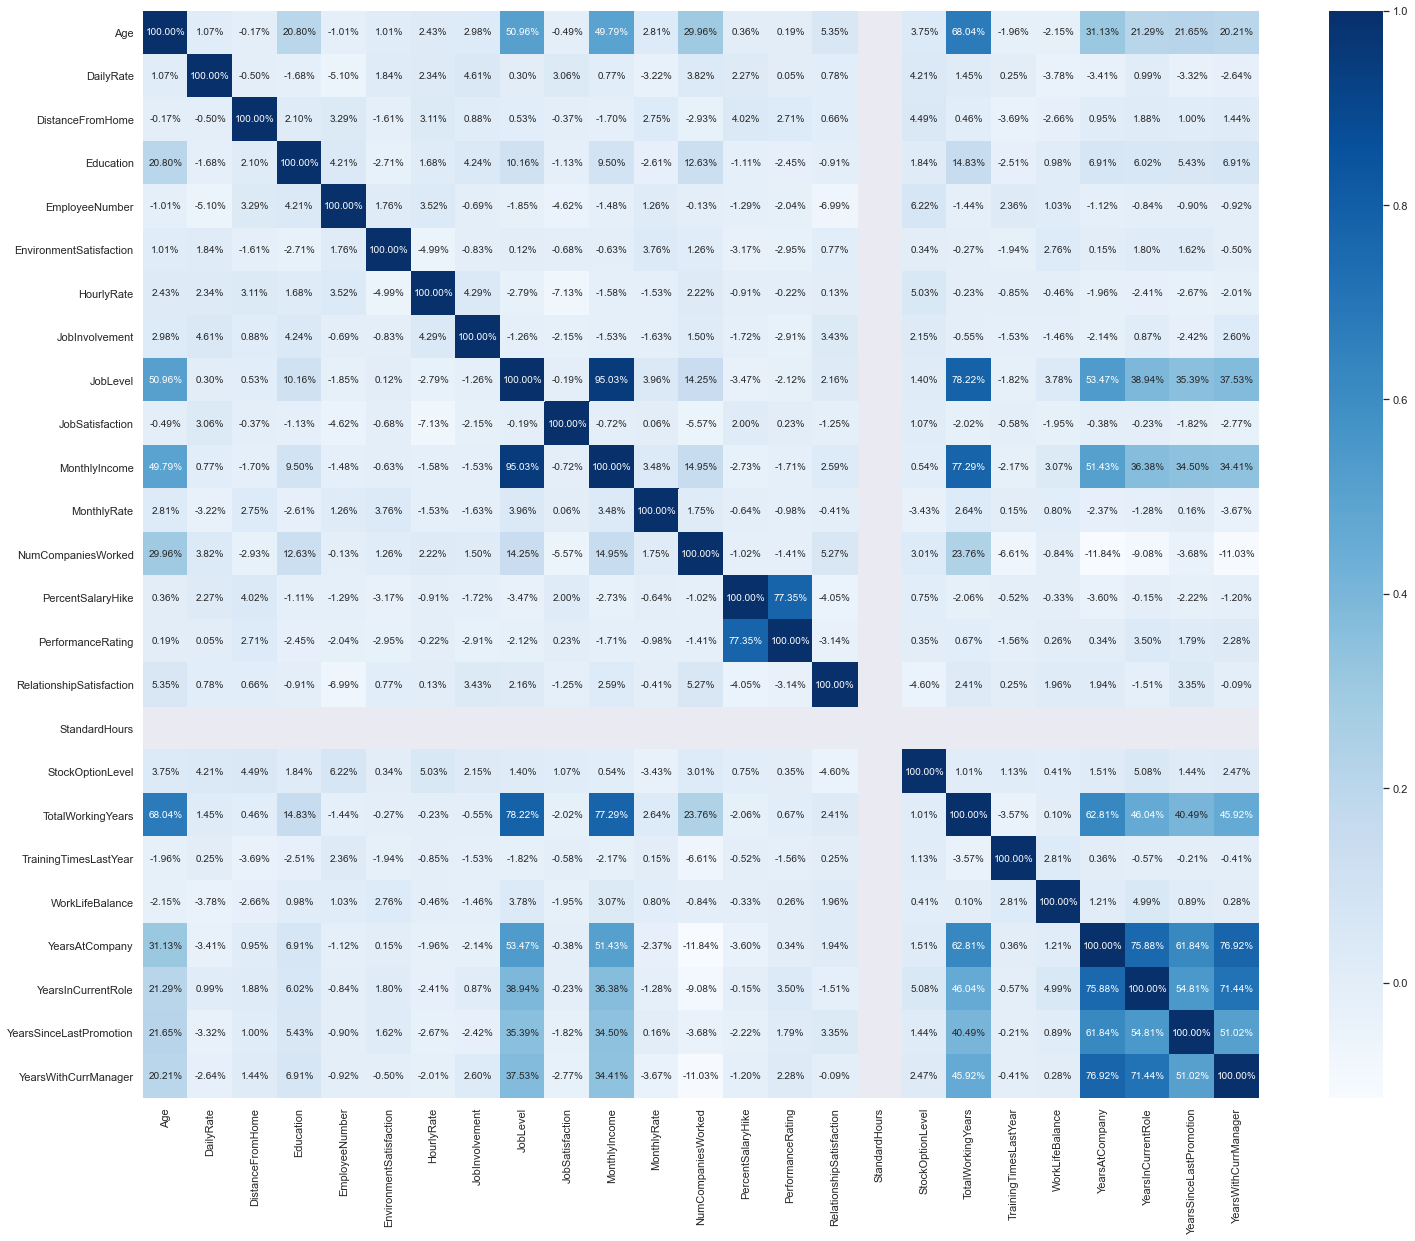

In [9]:
plt.subplots(figsize=(25, 20))
sns.heatmap(hr_df.corr(), annot=True, fmt='.2%', cmap='Blues');
# sns.heatmap(hr_df[['HourlyRate','DailyRate','MonthlyRate']].corr(), annot=True, fmt='.2%', cmap='Blues')

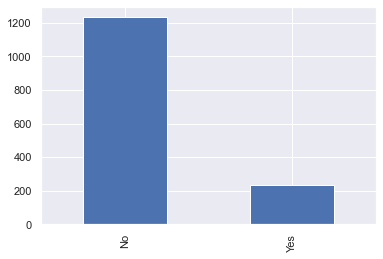

In [10]:
ax = hr_df['Attrition'].value_counts().plot(kind='bar');

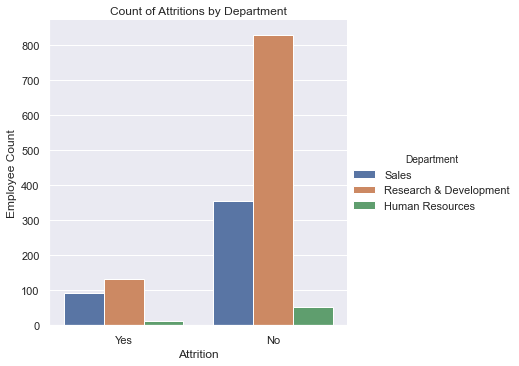

In [11]:
fig = sns.catplot(x='Attrition', kind='count', hue='Department' ,data=hr_df )
fig.set(xlabel='Attrition', ylabel="Employee Count", title="Count of Attritions by Department");

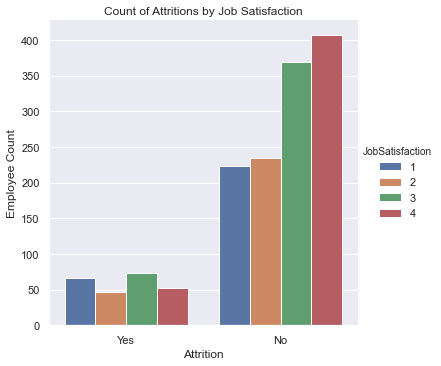

In [12]:
fig = sns.catplot(x='Attrition', kind='count', hue='JobSatisfaction' ,data=hr_df )
fig.set(xlabel='Attrition', ylabel="Employee Count", title="Count of Attritions by Job Satisfaction");

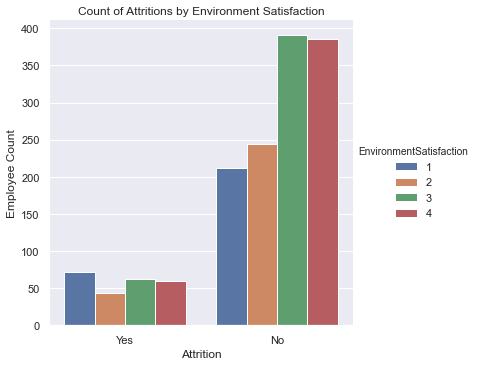

In [13]:
fig = sns.catplot(x='Attrition', kind='count', hue='EnvironmentSatisfaction' ,data=hr_df )
fig.set(xlabel='Attrition', ylabel="Employee Count", title="Count of Attritions by Environment Satisfaction");

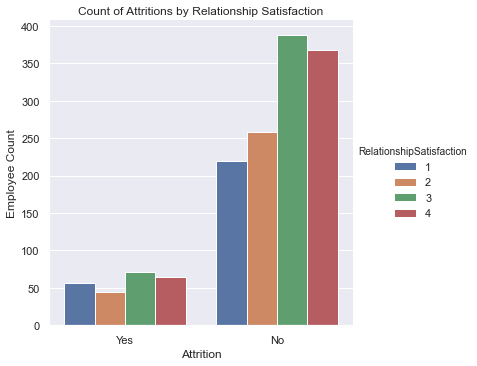

In [14]:
fig = sns.catplot(x='Attrition', kind='count', hue='RelationshipSatisfaction' ,data=hr_df )
fig.set(xlabel='Attrition', ylabel="Employee Count", title="Count of Attritions by Relationship Satisfaction");

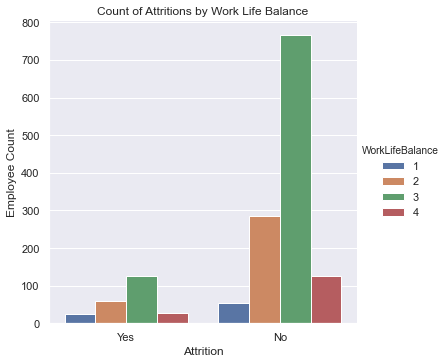

In [15]:
fig = sns.catplot(x='Attrition', kind='count', hue='WorkLifeBalance' ,data=hr_df )
fig.set(xlabel='Attrition', ylabel="Employee Count", title="Count of Attritions by Work Life Balance");

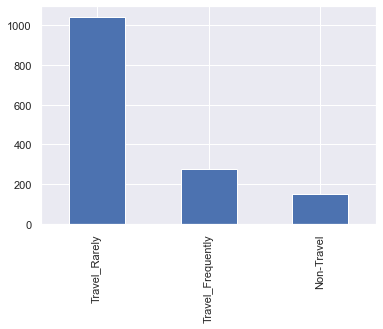

In [16]:
hr_df['BusinessTravel'].value_counts().plot(kind='bar')

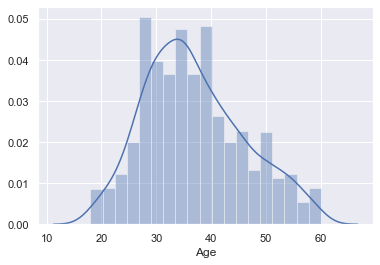

In [17]:
sns.distplot(hr_df['Age'])

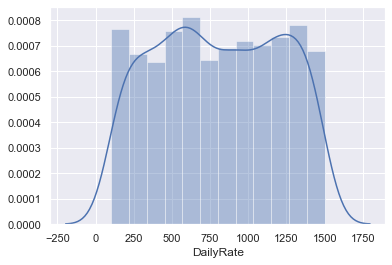

In [18]:
sns.distplot(hr_df['DailyRate'])

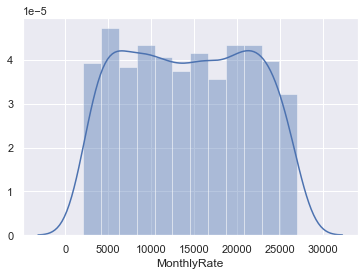

In [19]:
sns.distplot(hr_df['MonthlyRate'])

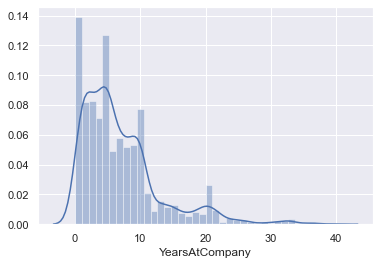

In [20]:
sns.distplot(hr_df['YearsAtCompany'])

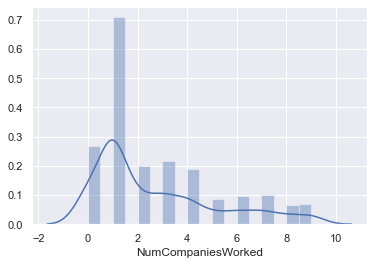

In [21]:
sns.distplot(hr_df['NumCompaniesWorked'])

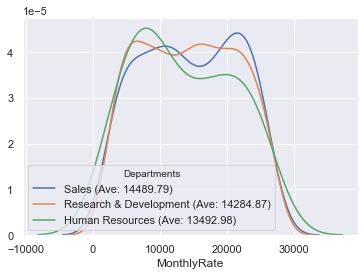

In [22]:
unique_depts = hr_df['Department'].unique()

for dept in unique_depts:
    subset = hr_df[hr_df['Department'] == dept]
    dept_mean = subset['MonthlyRate'].mean()
    dept_label = '{} (Ave: {:.2f})'.format(dept, dept_mean)
    sns.distplot(subset['MonthlyRate'], hist=False, label=dept_label)

plt.legend(title='Departments');

# EDA for those who were Attrited

In [23]:
leaver_df = hr_df[hr_df['Attrition'] == 'Yes']

In [24]:
leaver_df.head(2)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0


In [25]:
leaver_df.describe(include='all')

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,237.000000,237,237,237.000000,237,237.000000,237.000000,237,237.000000,237.000000,237,237.000000,237.000000,237.000000,237,237.000000,237,237.000000,237.000000,237.000000,237,237,237.000000,237.000000,237.000000,237.0,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000
unique,NaN,1,3,NaN,3,NaN,NaN,6,NaN,NaN,2,NaN,NaN,NaN,9,NaN,3,NaN,NaN,NaN,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Yes,Travel_Rarely,NaN,Research & Development,NaN,NaN,Life Sciences,NaN,NaN,Male,NaN,NaN,NaN,Laboratory Technician,NaN,Single,NaN,NaN,NaN,Y,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,237,156,NaN,133,NaN,NaN,89,NaN,NaN,150,NaN,NaN,NaN,62,NaN,120,NaN,NaN,NaN,237,127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,33.607595,NaN,NaN,750.362869,NaN,10.632911,2.839662,NaN,1010.345992,2.464135,NaN,65.573840,2.518987,1.637131,NaN,2.468354,NaN,4787.092827,14559.308017,2.940928,NaN,NaN,15.097046,3.156118,2.599156,80.0,0.527426,8.244726,2.624473,2.658228,5.130802,2.902954,1.945148,2.852321
std,9.689350,NaN,NaN,401.899519,NaN,8.452525,1.008244,NaN,580.750572,1.169791,NaN,20.099958,0.773405,0.940594,NaN,1.118058,NaN,3640.210367,7208.153264,2.678519,NaN,NaN,3.770294,0.363735,1.125437,0.0,0.856361,7.169204,1.254784,0.816453,5.949984,3.174827,3.153077,3.143349
min,18.000000,NaN,NaN,103.000000,NaN,1.000000,1.000000,NaN,1.000000,1.000000,NaN,31.000000,1.000000,1.000000,NaN,1.000000,NaN,1009.000000,2326.000000,0.000000,NaN,NaN,11.000000,3.000000,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,NaN,NaN,408.000000,NaN,3.000000,2.000000,NaN,514.000000,1.000000,NaN,50.000000,2.000000,1.000000,NaN,1.000000,NaN,2373.000000,8870.000000,1.000000,NaN,NaN,12.000000,3.000000,2.000000,80.0,0.000000,3.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000
50%,32.000000,NaN,NaN,699.000000,NaN,9.000000,3.000000,NaN,1017.000000,3.000000,NaN,66.000000,3.000000,1.000000,NaN,3.000000,NaN,3202.000000,14618.000000,1.000000,NaN,NaN,14.000000,3.000000,3.000000,80.0,0.000000,7.000000,2.000000,3.000000,3.000000,2.000000,1.000000,2.000000
75%,39.000000,NaN,NaN,1092.000000,NaN,17.000000,4.000000,NaN,1486.000000,4.000000,NaN,84.000000,3.000000,2.000000,NaN,3.000000,NaN,5916.000000,21081.000000,5.000000,NaN,NaN,17.000000,3.000000,4.000000,80.0,1.000000,10.000000,3.000000,3.000000,7.000000,4.000000,2.000000,5.000000


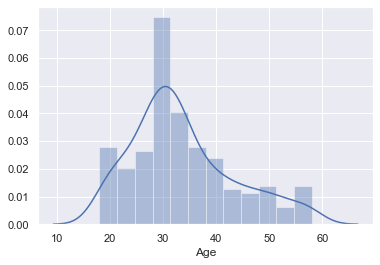

In [26]:
sns.distplot(leaver_df['Age'])

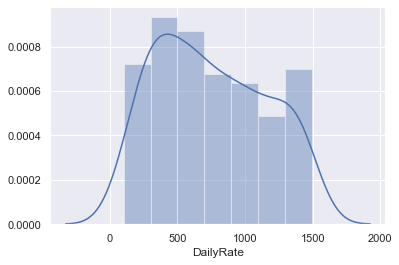

In [27]:
sns.distplot(leaver_df['DailyRate'])

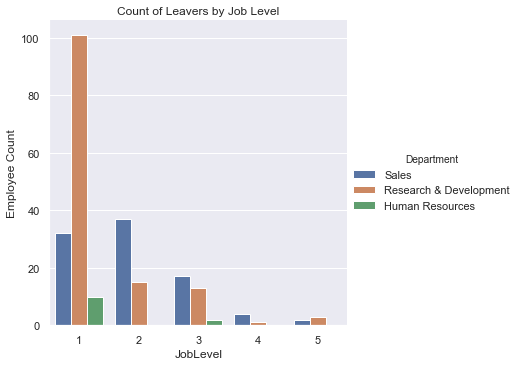

In [28]:
fig = sns.catplot(x='JobLevel', kind='count', hue='Department', data=leaver_df )
fig.set(xlabel='JobLevel', ylabel="Employee Count", title="Count of Leavers by Job Level");

In [29]:
leaver_df[leaver_df['Department'] == 'Research & Development']['JobRole'].value_counts()

Laboratory Technician        62
Research Scientist           47
Manufacturing Director       10
Healthcare Representative     9
Manager                       3
Research Director             2
Name: JobRole, dtype: int64

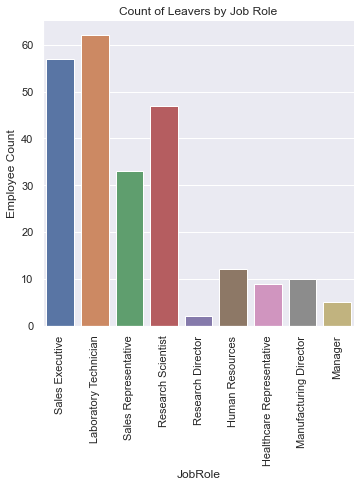

In [30]:
fig = sns.catplot(x='JobRole', kind='count', data=leaver_df )
fig.set(xlabel='JobRole', ylabel="Employee Count", title="Count of Leavers by Job Role")
fig.set_xticklabels(rotation=90);

In [31]:
leaver_df[leaver_df['Department'] == 'Research & Development'].describe(include='all')

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,133.000000,133,133,133.000000,133,133.000000,133.000000,133,133.000000,133.000000,133,133.000000,133.000000,133.000000,133,133.000000,133,133.000000,133.000000,133.000000,133,133,133.000000,133.000000,133.000000,133.0,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000
unique,NaN,1,3,NaN,1,NaN,NaN,4,NaN,NaN,2,NaN,NaN,NaN,6,NaN,3,NaN,NaN,NaN,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Yes,Travel_Rarely,NaN,Research & Development,NaN,NaN,Life Sciences,NaN,NaN,Male,NaN,NaN,NaN,Laboratory Technician,NaN,Single,NaN,NaN,NaN,Y,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,133,88,NaN,133,NaN,NaN,59,NaN,NaN,90,NaN,NaN,NaN,62,NaN,66,NaN,NaN,NaN,133,74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,33.473684,NaN,NaN,754.548872,NaN,10.263158,2.827068,NaN,949.744361,2.473684,NaN,66.834586,2.556391,1.421053,NaN,2.458647,NaN,4108.075188,14145.345865,2.924812,NaN,NaN,15.308271,3.195489,2.518797,80.0,0.518797,8.082707,2.586466,2.578947,4.954887,2.706767,1.872180,2.849624
std,9.902233,NaN,NaN,405.924561,NaN,8.386402,1.026256,NaN,557.743053,1.190740,NaN,20.579182,0.711523,0.872219,NaN,1.118110,NaN,3393.026241,7164.570549,2.675999,NaN,NaN,4.013576,0.398076,1.165160,0.0,0.812791,7.332002,1.256063,0.863489,6.048872,3.192752,3.262304,3.090788
min,18.000000,NaN,NaN,103.000000,NaN,1.000000,1.000000,NaN,4.000000,1.000000,NaN,31.000000,1.000000,1.000000,NaN,1.000000,NaN,1009.000000,2396.000000,0.000000,NaN,NaN,11.000000,3.000000,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,NaN,NaN,381.000000,NaN,3.000000,2.000000,NaN,440.000000,1.000000,NaN,50.000000,2.000000,1.000000,NaN,1.000000,NaN,2362.000000,8269.000000,1.000000,NaN,NaN,12.000000,3.000000,1.000000,80.0,0.000000,3.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000
50%,31.000000,NaN,NaN,699.000000,NaN,8.000000,3.000000,NaN,994.000000,3.000000,NaN,67.000000,3.000000,1.000000,NaN,3.000000,NaN,2759.000000,14180.000000,1.000000,NaN,NaN,14.000000,3.000000,3.000000,80.0,0.000000,7.000000,2.000000,3.000000,3.000000,2.000000,1.000000,2.000000
75%,38.000000,NaN,NaN,1097.000000,NaN,16.000000,4.000000,NaN,1389.000000,4.000000,NaN,85.000000,3.000000,1.000000,NaN,3.000000,NaN,4213.000000,20366.000000,5.000000,NaN,NaN,18.000000,3.000000,4.000000,80.0,1.000000,10.000000,3.000000,3.000000,7.000000,4.000000,2.000000,5.000000


# Plotting Employees

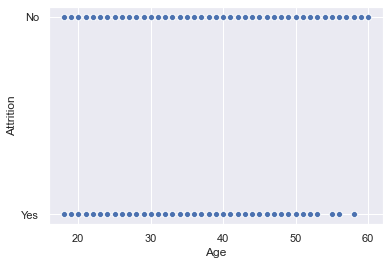

In [32]:
sns.scatterplot(x='Age', y='Attrition', data=hr_df)

# Train Test Split

In [33]:
target = hr_df['Attrition']
features = hr_df.drop(['Attrition'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=432)

Must retain the order of columns for usage later on.

In [34]:
train_df = x_train.copy()
train_df.insert(0, 'Attrition', y_train)
train_df.reset_index(drop=True, inplace=True)
train_df

,Attrition,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,No,31,Travel_Rarely,1274,Research & Development,9,1,Life Sciences,581,3,Male,33,3,3,Manufacturing Director,2,Divorced,10648,14394,1,Y,No,25,4,4,80,1,13,6,4,13,8,0,8
1,No,28,Travel_Rarely,640,Research & Development,1,3,Technical Degree,1301,4,Male,84,3,1,Research Scientist,1,Single,2080,4732,2,Y,No,11,3,2,80,0,5,2,2,3,2,1,2
2,No,55,Travel_Frequently,1091,Research & Development,2,1,Life Sciences,1096,4,Male,65,3,3,Manufacturing Director,2,Married,10976,15813,3,Y,No,18,3,2,80,1,23,4,3,3,2,1,2
3,No,36,Travel_Rarely,430,Research & Development,2,4,Other,1847,4,Female,73,3,2,Research Scientist,2,Married,6962,19573,4,Y,Yes,22,4,4,80,1,15,2,3,1,0,0,0
4,No,53,Travel_Rarely,102,Research & Development,23,4,Life Sciences,901,4,Female,72,3,4,Research Director,4,Single,14275,20206,6,Y,No,18,3,3,80,0,33,0,3,12,9,3,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,Yes,55,Travel_Rarely,436,Sales,2,1,Medical,842,3,Male,37,3,2,Sales Executive,4,Single,5160,21519,4,Y,No,16,3,3,80,0,12,3,2,9,7,7,3
1172,Yes,25,Travel_Rarely,240,Sales,5,3,Marketing,142,3,Male,46,2,2,Sales Executive,3,Single,5744,26959,1,Y,Yes,11,3,4,80,0,6,1,3,6,4,0,3
1173,No,29,Travel_Rarely,991,Sales,5,3,Medical,1669,1,Male,43,2,2,Sales Executive,2,Divorced,4187,3356,1,Y,Yes,13,3,2,80,1,10,3,2,10,0,0,9
1174,No,24,Non-Travel,1269,Research & Development,4,1,Life Sciences,888,1,Male,46,2,1,Laboratory Technician,4,Married,3162,10778,0,Y,No,17,3,4,80,0,6,2,2,5,2,3,4


Quick sanity check if the re-inserted ```Attrition``` column still has the same values with the original ```hr_df```. Join the train_df and hr_df on ```EmployeeNumber``` resulting to a new dataframe, ```check_train_df```.

In [35]:
check_train_df = pd.merge(left=train_df, right=hr_df, on=['EmployeeNumber'])

 If ```check_train_df.Attrition``` is not equal with ```hr_df.Attrition``` it should show some rows. Luckily, it didn't, so the reinserted Attrition column in ```train_df``` still retained the original values.

In [36]:
check_train_df[(check_train_df['Attrition_x'] != check_train_df['Attrition_y'])]

,Attrition_x,Age_x,BusinessTravel_x,DailyRate_x,Department_x,DistanceFromHome_x,Education_x,EducationField_x,EmployeeNumber,EnvironmentSatisfaction_x,Gender_x,HourlyRate_x,JobInvolvement_x,JobLevel_x,JobRole_x,JobSatisfaction_x,MaritalStatus_x,MonthlyIncome_x,MonthlyRate_x,NumCompaniesWorked_x,Over18_x,OverTime_x,PercentSalaryHike_x,PerformanceRating_x,RelationshipSatisfaction_x,StandardHours_x,StockOptionLevel_x,TotalWorkingYears_x,TrainingTimesLastYear_x,WorkLifeBalance_x,YearsAtCompany_x,YearsInCurrentRole_x,YearsSinceLastPromotion_x,YearsWithCurrManager_x,Age_y,Attrition_y,BusinessTravel_y,DailyRate_y,Department_y,DistanceFromHome_y,Education_y,EducationField_y,EnvironmentSatisfaction_y,Gender_y,HourlyRate_y,JobInvolvement_y,JobLevel_y,JobRole_y,JobSatisfaction_y,MaritalStatus_y,MonthlyIncome_y,MonthlyRate_y,NumCompaniesWorked_y,Over18_y,OverTime_y,PercentSalaryHike_y,PerformanceRating_y,RelationshipSatisfaction_y,StandardHours_y,StockOptionLevel_y,TotalWorkingYears_y,TrainingTimesLastYear_y,WorkLifeBalance_y,YearsAtCompany_y,YearsInCurrentRole_y,YearsSinceLastPromotion_y,YearsWithCurrManager_y


For the ```test_df```, do the same method as that for ```train_df```. A quick check ensured that the reinserted Attrition column still has the original values.

In [37]:
test_df = x_test.copy()
test_df.insert(0, 'Attrition', y_test)
test_df.reset_index(drop=True, inplace=True)
test_df

,Attrition,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,Yes,50,Travel_Rarely,869,Sales,3,2,Marketing,47,1,Male,86,2,1,Sales Representative,3,Married,2683,3810,1,Y,Yes,14,3,3,80,0,3,2,3,3,2,0,2
1,No,27,Travel_Rarely,1103,Research & Development,14,3,Life Sciences,1244,1,Male,42,3,1,Research Scientist,1,Married,2235,14377,1,Y,Yes,14,3,4,80,2,9,3,2,9,7,6,8
2,No,36,Travel_Rarely,559,Research & Development,12,4,Life Sciences,1614,3,Female,76,3,2,Manufacturing Director,3,Married,4663,12421,9,Y,Yes,12,3,2,80,2,7,2,3,3,2,1,1
3,No,33,Travel_Rarely,589,Research & Development,28,4,Life Sciences,1549,2,Male,79,3,2,Laboratory Technician,3,Married,5207,22949,1,Y,Yes,12,3,2,80,1,15,3,3,15,14,5,7
4,No,32,Non-Travel,1109,Research & Development,29,4,Medical,1046,4,Female,69,3,1,Laboratory Technician,3,Single,4025,11135,9,Y,No,12,3,2,80,0,10,2,3,8,7,7,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,No,35,Travel_Rarely,1296,Research & Development,5,4,Technical Degree,464,3,Male,62,3,3,Manufacturing Director,2,Single,8095,18264,0,Y,No,13,3,4,80,0,17,5,3,16,6,0,13
290,Yes,22,Travel_Rarely,617,Research & Development,3,1,Life Sciences,926,2,Female,34,3,2,Manufacturing Director,3,Married,4171,10022,0,Y,Yes,19,3,1,80,1,4,3,4,3,2,0,2
291,No,35,Travel_Frequently,853,Sales,18,5,Life Sciences,74,2,Male,71,3,3,Sales Executive,1,Married,9069,11031,1,Y,No,22,4,4,80,1,9,3,2,9,8,1,8
292,No,34,Travel_Rarely,665,Research & Development,6,4,Other,138,1,Female,41,3,2,Research Scientist,3,Single,4809,12482,1,Y,No,14,3,3,80,0,16,3,3,16,13,2,10


In [38]:
check_test_df = pd.merge(left=test_df, right=hr_df, on=['EmployeeNumber'])
check_test_df[(check_test_df['Attrition_x'] != check_test_df['Attrition_y'])]

,Attrition_x,Age_x,BusinessTravel_x,DailyRate_x,Department_x,DistanceFromHome_x,Education_x,EducationField_x,EmployeeNumber,EnvironmentSatisfaction_x,Gender_x,HourlyRate_x,JobInvolvement_x,JobLevel_x,JobRole_x,JobSatisfaction_x,MaritalStatus_x,MonthlyIncome_x,MonthlyRate_x,NumCompaniesWorked_x,Over18_x,OverTime_x,PercentSalaryHike_x,PerformanceRating_x,RelationshipSatisfaction_x,StandardHours_x,StockOptionLevel_x,TotalWorkingYears_x,TrainingTimesLastYear_x,WorkLifeBalance_x,YearsAtCompany_x,YearsInCurrentRole_x,YearsSinceLastPromotion_x,YearsWithCurrManager_x,Age_y,Attrition_y,BusinessTravel_y,DailyRate_y,Department_y,DistanceFromHome_y,Education_y,EducationField_y,EnvironmentSatisfaction_y,Gender_y,HourlyRate_y,JobInvolvement_y,JobLevel_y,JobRole_y,JobSatisfaction_y,MaritalStatus_y,MonthlyIncome_y,MonthlyRate_y,NumCompaniesWorked_y,Over18_y,OverTime_y,PercentSalaryHike_y,PerformanceRating_y,RelationshipSatisfaction_y,StandardHours_y,StockOptionLevel_y,TotalWorkingYears_y,TrainingTimesLastYear_y,WorkLifeBalance_y,YearsAtCompany_y,YearsInCurrentRole_y,YearsSinceLastPromotion_y,YearsWithCurrManager_y


# One-Hot Encoding the Training Dataset

In [39]:
nominal_categories = ['Attrition', 'BusinessTravel', 'Department', 'EducationField', 
                      'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']

In [40]:
train_df[nominal_categories].columns

Index(['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender',
       'JobRole', 'MaritalStatus', 'Over18', 'OverTime'],
      dtype='object')

In [41]:
hr_df[nominal_categories].columns

Index(['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender',
       'JobRole', 'MaritalStatus', 'Over18', 'OverTime'],
      dtype='object')

In [42]:
ohe = OneHotEncoder(categories='auto', drop='first')
ohe.fit(train_df[nominal_categories])
train_arr = ohe.transform(train_df[nominal_categories]).toarray()
train_arr

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.]])

In [43]:
train_cols = ohe.get_feature_names()
train_cols_list = train_cols.tolist()
train_cols_list

['x0_Yes',
 'x1_Travel_Frequently',
 'x1_Travel_Rarely',
 'x2_Research & Development',
 'x2_Sales',
 'x3_Life Sciences',
 'x3_Marketing',
 'x3_Medical',
 'x3_Other',
 'x3_Technical Degree',
 'x4_Male',
 'x5_Human Resources',
 'x5_Laboratory Technician',
 'x5_Manager',
 'x5_Manufacturing Director',
 'x5_Research Director',
 'x5_Research Scientist',
 'x5_Sales Executive',
 'x5_Sales Representative',
 'x6_Married',
 'x6_Single',
 'x8_Yes']

In [44]:
new_cols_list = []
for index, value in enumerate(train_cols_list):
    new_cols_list.append(nominal_categories[int(value[1])] + value[2:])
    continue
new_cols_list

['Attrition_Yes',
 'BusinessTravel_Travel_Frequently',
 'BusinessTravel_Travel_Rarely',
 'Department_Research & Development',
 'Department_Sales',
 'EducationField_Life Sciences',
 'EducationField_Marketing',
 'EducationField_Medical',
 'EducationField_Other',
 'EducationField_Technical Degree',
 'Gender_Male',
 'JobRole_Human Resources',
 'JobRole_Laboratory Technician',
 'JobRole_Manager',
 'JobRole_Manufacturing Director',
 'JobRole_Research Director',
 'JobRole_Research Scientist',
 'JobRole_Sales Executive',
 'JobRole_Sales Representative',
 'MaritalStatus_Married',
 'MaritalStatus_Single',
 'OverTime_Yes']

In [45]:
train_ohe_df = pd.DataFrame(train_arr, columns=new_cols_list)
train_ohe_df

,Attrition_Yes,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Male,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1172,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
1173,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1174,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [46]:
train_df = pd.merge(left=train_df, right=train_ohe_df, left_index=True, right_index=True)
train_df

,Attrition,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition_Yes,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Male,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,No,31,Travel_Rarely,1274,Research & Development,9,1,Life Sciences,581,3,Male,33,3,3,Manufacturing Director,2,Divorced,10648,14394,1,Y,No,25,4,4,80,1,13,6,4,13,8,0,8,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,No,28,Travel_Rarely,640,Research & Development,1,3,Technical Degree,1301,4,Male,84,3,1,Research Scientist,1,Single,2080,4732,2,Y,No,11,3,2,80,0,5,2,2,3,2,1,2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,No,55,Travel_Frequently,1091,Research & Development,2,1,Life Sciences,1096,4,Male,65,3,3,Manufacturing Director,2,Married,10976,15813,3,Y,No,18,3,2,80,1,23,4,3,3,2,1,2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,No,36,Travel_Rarely,430,Research & Development,2,4,Other,1847,4,Female,73,3,2,Research Scientist,2,Married,6962,19573,4,Y,Yes,22,4,4,80,1,15,2,3,1,0,0,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,No,53,Travel_Rarely,102,Research & Development,23,4,Life Sciences,901,4,Female,72,3,4,Research Director,4,Single,14275,20206,6,Y,No,18,3,3,80,0,33,0,3,12,9,3,8,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,Yes,55,Travel_Rarely,436,Sales,2,1,Medical,842,3,Male,37,3,2,Sales Executive,4,Single,5160,21519,4,Y,No,16,3,3,80,0,12,3,2,9,7,7,3,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1172,Yes,25,Travel_Rarely,240,Sales,5,3,Marketing,142,3,Male,46,2,2,Sales Executive,3,Single,5744,26959,1,Y,Yes,11,3,4,80,0,6,1,3,6,4,0,3,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
1173,No,29,Travel_Rarely,991,Sales,5,3,Medical,1669,1,Male,43,2,2,Sales Executive,2,Divorced,4187,3356,1,Y,Yes,13,3,2,80,1,10,3,2,10,0,0,9,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1174,No,24,Non-Travel,1269,Research & Development,4,1,Life Sciences,888,1,Male,46,2,1,Laboratory Technician,4,Married,3162,10778,0,Y,No,17,3,4,80,0,6,2,2,5,2,3,4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Drop the original nominal category columns so that only the one-hot encoded columns remain

In [47]:
train_df.drop(nominal_categories, axis=1, inplace=True)
train_df

,Age,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition_Yes,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Male,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,31,1274,9,1,581,3,33,3,3,2,10648,14394,1,25,4,4,80,1,13,6,4,13,8,0,8,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,28,640,1,3,1301,4,84,3,1,1,2080,4732,2,11,3,2,80,0,5,2,2,3,2,1,2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,55,1091,2,1,1096,4,65,3,3,2,10976,15813,3,18,3,2,80,1,23,4,3,3,2,1,2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,36,430,2,4,1847,4,73,3,2,2,6962,19573,4,22,4,4,80,1,15,2,3,1,0,0,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,53,102,23,4,901,4,72,3,4,4,14275,20206,6,18,3,3,80,0,33,0,3,12,9,3,8,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,55,436,2,1,842,3,37,3,2,4,5160,21519,4,16,3,3,80,0,12,3,2,9,7,7,3,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1172,25,240,5,3,142,3,46,2,2,3,5744,26959,1,11,3,4,80,0,6,1,3,6,4,0,3,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
1173,29,991,5,3,1669,1,43,2,2,2,4187,3356,1,13,3,2,80,1,10,3,2,10,0,0,9,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1174,24,1269,4,1,888,1,46,2,1,4,3162,10778,0,17,3,4,80,0,6,2,2,5,2,3,4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [48]:
# Drop EmployeeNUmber
train_df.drop(['EmployeeNumber'], axis=1, inplace=True)

# Applying OHE to the Test Dataset

In [49]:
test_df.append({'Over18': 'N'}, ignore_index=True)

,Attrition,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,Yes,50.0,Travel_Rarely,869.0,Sales,3.0,2.0,Marketing,47.0,1.0,Male,86.0,2.0,1.0,Sales Representative,3.0,Married,2683.0,3810.0,1.0,Y,Yes,14.0,3.0,3.0,80.0,0.0,3.0,2.0,3.0,3.0,2.0,0.0,2.0
1,No,27.0,Travel_Rarely,1103.0,Research & Development,14.0,3.0,Life Sciences,1244.0,1.0,Male,42.0,3.0,1.0,Research Scientist,1.0,Married,2235.0,14377.0,1.0,Y,Yes,14.0,3.0,4.0,80.0,2.0,9.0,3.0,2.0,9.0,7.0,6.0,8.0
2,No,36.0,Travel_Rarely,559.0,Research & Development,12.0,4.0,Life Sciences,1614.0,3.0,Female,76.0,3.0,2.0,Manufacturing Director,3.0,Married,4663.0,12421.0,9.0,Y,Yes,12.0,3.0,2.0,80.0,2.0,7.0,2.0,3.0,3.0,2.0,1.0,1.0
3,No,33.0,Travel_Rarely,589.0,Research & Development,28.0,4.0,Life Sciences,1549.0,2.0,Male,79.0,3.0,2.0,Laboratory Technician,3.0,Married,5207.0,22949.0,1.0,Y,Yes,12.0,3.0,2.0,80.0,1.0,15.0,3.0,3.0,15.0,14.0,5.0,7.0
4,No,32.0,Non-Travel,1109.0,Research & Development,29.0,4.0,Medical,1046.0,4.0,Female,69.0,3.0,1.0,Laboratory Technician,3.0,Single,4025.0,11135.0,9.0,Y,No,12.0,3.0,2.0,80.0,0.0,10.0,2.0,3.0,8.0,7.0,7.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,Yes,22.0,Travel_Rarely,617.0,Research & Development,3.0,1.0,Life Sciences,926.0,2.0,Female,34.0,3.0,2.0,Manufacturing Director,3.0,Married,4171.0,10022.0,0.0,Y,Yes,19.0,3.0,1.0,80.0,1.0,4.0,3.0,4.0,3.0,2.0,0.0,2.0
291,No,35.0,Travel_Frequently,853.0,Sales,18.0,5.0,Life Sciences,74.0,2.0,Male,71.0,3.0,3.0,Sales Executive,1.0,Married,9069.0,11031.0,1.0,Y,No,22.0,4.0,4.0,80.0,1.0,9.0,3.0,2.0,9.0,8.0,1.0,8.0
292,No,34.0,Travel_Rarely,665.0,Research & Development,6.0,4.0,Other,138.0,1.0,Female,41.0,3.0,2.0,Research Scientist,3.0,Single,4809.0,12482.0,1.0,Y,No,14.0,3.0,3.0,80.0,0.0,16.0,3.0,3.0,16.0,13.0,2.0,10.0
293,No,33.0,Travel_Rarely,147.0,Research & Development,4.0,4.0,Medical,305.0,3.0,Female,47.0,2.0,1.0,Research Scientist,2.0,Married,2622.0,13248.0,6.0,Y,No,21.0,4.0,4.0,80.0,0.0,7.0,3.0,3.0,3.0,2.0,1.0,1.0


In [50]:
test_arr = ohe.transform(test_df[nominal_categories]).toarray()

In [51]:
test_cols = ohe.get_feature_names()
test_cols_list = test_cols.tolist()

In [52]:
new_cols_list = []
for index, value in enumerate(test_cols_list):
    new_cols_list.append(nominal_categories[int(value[1])] + value[2:])
    continue
new_cols_list

['Attrition_Yes',
 'BusinessTravel_Travel_Frequently',
 'BusinessTravel_Travel_Rarely',
 'Department_Research & Development',
 'Department_Sales',
 'EducationField_Life Sciences',
 'EducationField_Marketing',
 'EducationField_Medical',
 'EducationField_Other',
 'EducationField_Technical Degree',
 'Gender_Male',
 'JobRole_Human Resources',
 'JobRole_Laboratory Technician',
 'JobRole_Manager',
 'JobRole_Manufacturing Director',
 'JobRole_Research Director',
 'JobRole_Research Scientist',
 'JobRole_Sales Executive',
 'JobRole_Sales Representative',
 'MaritalStatus_Married',
 'MaritalStatus_Single',
 'OverTime_Yes']

In [53]:
test_ohe_df = pd.DataFrame(test_arr, columns=new_cols_list)
test_ohe_df

,Attrition_Yes,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Male,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
1,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
2,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
290,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
291,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
292,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [54]:
test_df = pd.merge(left=test_df, right=test_ohe_df, left_index=True, right_index=True)
test_df

,Attrition,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition_Yes,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Male,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,Yes,50,Travel_Rarely,869,Sales,3,2,Marketing,47,1,Male,86,2,1,Sales Representative,3,Married,2683,3810,1,Y,Yes,14,3,3,80,0,3,2,3,3,2,0,2,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
1,No,27,Travel_Rarely,1103,Research & Development,14,3,Life Sciences,1244,1,Male,42,3,1,Research Scientist,1,Married,2235,14377,1,Y,Yes,14,3,4,80,2,9,3,2,9,7,6,8,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
2,No,36,Travel_Rarely,559,Research & Development,12,4,Life Sciences,1614,3,Female,76,3,2,Manufacturing Director,3,Married,4663,12421,9,Y,Yes,12,3,2,80,2,7,2,3,3,2,1,1,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,No,33,Travel_Rarely,589,Research & Development,28,4,Life Sciences,1549,2,Male,79,3,2,Laboratory Technician,3,Married,5207,22949,1,Y,Yes,12,3,2,80,1,15,3,3,15,14,5,7,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,No,32,Non-Travel,1109,Research & Development,29,4,Medical,1046,4,Female,69,3,1,Laboratory Technician,3,Single,4025,11135,9,Y,No,12,3,2,80,0,10,2,3,8,7,7,7,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,No,35,Travel_Rarely,1296,Research & Development,5,4,Technical Degree,464,3,Male,62,3,3,Manufacturing Director,2,Single,8095,18264,0,Y,No,13,3,4,80,0,17,5,3,16,6,0,13,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
290,Yes,22,Travel_Rarely,617,Research & Development,3,1,Life Sciences,926,2,Female,34,3,2,Manufacturing Director,3,Married,4171,10022,0,Y,Yes,19,3,1,80,1,4,3,4,3,2,0,2,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
291,No,35,Travel_Frequently,853,Sales,18,5,Life Sciences,74,2,Male,71,3,3,Sales Executive,1,Married,9069,11031,1,Y,No,22,4,4,80,1,9,3,2,9,8,1,8,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
292,No,34,Travel_Rarely,665,Research & Development,6,4,Other,138,1,Female,41,3,2,Research Scientist,3,Single,4809,12482,1,Y,No,14,3,3,80,0,16,3,3,16,13,2,10,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [55]:
test_df.drop(nominal_categories, axis=1, inplace=True)
test_df

,Age,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition_Yes,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Male,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,50,869,3,2,47,1,86,2,1,3,2683,3810,1,14,3,3,80,0,3,2,3,3,2,0,2,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
1,27,1103,14,3,1244,1,42,3,1,1,2235,14377,1,14,3,4,80,2,9,3,2,9,7,6,8,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
2,36,559,12,4,1614,3,76,3,2,3,4663,12421,9,12,3,2,80,2,7,2,3,3,2,1,1,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,33,589,28,4,1549,2,79,3,2,3,5207,22949,1,12,3,2,80,1,15,3,3,15,14,5,7,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,32,1109,29,4,1046,4,69,3,1,3,4025,11135,9,12,3,2,80,0,10,2,3,8,7,7,7,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,35,1296,5,4,464,3,62,3,3,2,8095,18264,0,13,3,4,80,0,17,5,3,16,6,0,13,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
290,22,617,3,1,926,2,34,3,2,3,4171,10022,0,19,3,1,80,1,4,3,4,3,2,0,2,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
291,35,853,18,5,74,2,71,3,3,1,9069,11031,1,22,4,4,80,1,9,3,2,9,8,1,8,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
292,34,665,6,4,138,1,41,3,2,3,4809,12482,1,14,3,3,80,0,16,3,3,16,13,2,10,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [56]:
# Drop EmployeeNUmber
test_df.drop(['EmployeeNumber'], axis=1, inplace=True)

# Logistic Regression

## Training Data

In [57]:
train_target = train_df['Attrition_Yes'] 
train_features = train_df.drop(['Attrition_Yes'], axis=1)

In [58]:
train_with_constant = sm.add_constant(train_features)

In [59]:
reg_logit = sm.Logit(train_target, train_with_constant)

In [60]:
logit_model = reg_logit.fit()

         Current function value: 0.281020
         Iterations: 35


c:\users\dana\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [61]:
logit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Attrition_Yes   No. Observations:                 1176
Model:                          Logit   Df Residuals:                     1131
Method:                           MLE   Df Model:                           44
Date:                Wed, 15 Apr 2020   Pseudo R-squ.:                  0.3521
Time:                        19:59:43   Log-Likelihood:                -330.48
converged:                      False   LL-Null:                       -510.10
Covariance Type:            nonrobust   LLR p-value:                 4.779e-51
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Age                                  -0.0365      0.015     -2.357      0.018      -0.067      -0.006
DailyRate                            -0.0003      0.000     -1.175      0.240      -0.001       0.000
DistanceFromHome                      0.0513      0.012      4.175      0.000       0.027       0.075
Education                             0.0353      0.101      0.351      0.725      -0.162       0.232
EnvironmentSatisfaction              -0.4787      0.096     -4.986      0.000      -0.667      -0.291
HourlyRate                            0.0037      0.005      0.726      0.468      -0.006       0.014
JobInvolvement                       -0.5206      0.141     -3.704      0.000      -0.796      -0.245
JobLevel                              0.3065      0.364      0.842      0.400      -0.407       1.020
JobSatisfaction                      -0.3370      0.094     -3.569      0.000      -0.522      -0.152
MonthlyIncome                     -5.593e-05   9.63e-05     -0.581      0.562      -0.000       0.000
MonthlyRate                          1.5e-05   1.44e-05      1.038      0.299   -1.33e-05    4.33e-05
NumCompaniesWorked                    0.2288      0.044      5.242      0.000       0.143       0.314
PercentSalaryHike                    -0.0208      0.046     -0.455      0.649      -0.111       0.069
PerformanceRating                     0.1351      0.459      0.294      0.768      -0.764       1.034
RelationshipSatisfaction             -0.2317      0.095     -2.451      0.014      -0.417      -0.046
StandardHours                        -0.2443    645.718     -0.000      1.000   -1265.829    1265.340
StockOptionLevel                     -0.3107      0.178     -1.748      0.080      -0.659       0.038
TotalWorkingYears                    -0.0675      0.034     -1.977      0.048      -0.134      -0.001
TrainingTimesLastYear                -0.2516      0.084     -2.978      0.003      -0.417      -0.086
WorkLifeBalance                      -0.4106      0.145     -2.826      0.005      -0.695      -0.126
YearsAtCompany                        0.1066      0.044      2.406      0.016       0.020       0.193
YearsInCurrentRole                   -0.1617      0.053     -3.070      0.002      -0.265      -0.058
YearsSinceLastPromotion               0.1651      0.049      3.383      0.001       0.069       0.261
YearsWithCurrManager                 -0.1479      0.053     -2.797      0.005      -0.252      -0.044
BusinessTravel_Travel_Frequently      1.7914      0.478      3.749      0.000       0.855       2.728
BusinessTravel_Travel_Rarely          1.0925      0.439      2.489      0.013       0.232       1.953
Department_Research & Development    20.7086   5.17e+04      0.000      1.000   -1.01e+05    1.01e+05
Department_Sales                     19.6141   5.17e+04      0.000      1.000   -1.01e+05    1.01e+05
EducationField_Life Sciences         -0.1984      0.904     -0.219      0.826  

In [62]:
def confusion_matrix(data,actual_values,model):
        
        # Confusion matrix 
        
        # Parameters
        # ----------
        # data: data frame or array
            # data is a data frame formatted in the same way as your input data (without the actual values)
            # e.g. const, var1, var2, etc. Order is very important!
        # actual_values: data frame or array
            # These are the actual values from the test_data
            # In the case of a logistic regression, it should be a single column with 0s and 1s
            
        # model: a LogitResults object
            # this is the variable where you have the fitted model 
            # e.g. results_log in this course
        # ----------
        
        #Predict the values using the Logit model
        pred_values = model.predict(data)
        # Specify the bins 
        bins=np.array([0,0.5,1])
        # Create a histogram, where if values are between 0 and 0.5 tell will be considered 0
        # if they are between 0.5 and 1, they will be considered 1
        cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
        # Calculate the accuracy
        accuracy = (cm[0,0]+cm[1,1])/cm.sum()
        # Return the confusion matrix and 
        return cm, accuracy

In [63]:
cm, acc = confusion_matrix(train_with_constant, train_target, logit_model)

In [64]:
cm

array([[969.,  23.],
       [ 96.,  88.]])

In [65]:
acc

0.8988095238095238

In [66]:
train_sensitivity = cm[0][0] / (cm[0][0] + cm[1][0])
train_sensitivity

0.9098591549295775

## Testing the Model

In [67]:
test_target = test_df['Attrition_Yes']
test_features = test_df.drop(['Attrition_Yes'], axis=1)
test_features = sm.add_constant(test_features)

In [68]:
cm, acc = confusion_matrix(test_features, test_target, logit_model)

In [69]:
cm

array([[230.,  11.],
       [ 36.,  17.]])

In [70]:
test_sensitivity = cm[0][0] / (cm[0][0] + cm[1][0])
test_sensitivity

0.8646616541353384

# Method 2: Standard Scaler then RFE then Logistic Regression

In [71]:
train_df.dtypes

Age                                    int64
DailyRate                              int64
DistanceFromHome                       int64
Education                              int64
EnvironmentSatisfaction                int64
HourlyRate                             int64
JobInvolvement                         int64
JobLevel                               int64
JobSatisfaction                        int64
MonthlyIncome                          int64
MonthlyRate                            int64
NumCompaniesWorked                     int64
PercentSalaryHike                      int64
PerformanceRating                      int64
RelationshipSatisfaction               int64
StandardHours                          int64
StockOptionLevel                       int64
TotalWorkingYears                      int64
TrainingTimesLastYear                  int64
WorkLifeBalance                        int64
YearsAtCompany                         int64
YearsInCurrentRole                     int64
YearsSince

In [73]:
scaler = StandardScaler()
scaler.fit(train_df.drop(['Attrition_Yes'], axis=1))
# scaler.transform(train_df)
scaled_train_df = scaler.transform(train_df.drop(['Attrition_Yes'], axis=1))
scaled_train_df = pd.DataFrame(scaled_train_df, columns=train_df.drop(['Attrition_Yes'], axis=1).columns)
scaled_train_df

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Male,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,-0.689868,1.143634,-0.016933,-1.917270,0.236912,-1.614977,0.392794,0.801481,-0.649704,0.837139,0.020201,-0.695759,2.687165,2.367856,1.190677,0.0,0.211383,0.199999,2.490413,1.758492,0.960155,1.019052,-0.677871,1.071443,-0.483733,0.640369,0.739844,-0.669534,1.177028,-0.352538,-0.669534,-0.235914,-0.311472,0.820263,-0.194814,-0.455403,-0.287877,3.008535,-0.243843,-0.482394,-0.541968,-0.239904,-0.904223,-0.674867,-0.632456
1,-1.021999,-0.409053,-1.006426,0.071887,1.156410,0.906036,0.392794,-0.981947,-1.562550,-0.952069,-1.338901,-0.295264,-1.159252,-0.422323,-0.659041,0.0,-0.944831,-0.823161,-0.617813,-1.093903,-0.655906,-0.615880,-0.372790,-0.601146,-0.483733,0.640369,0.739844,-0.669534,-0.849597,-0.352538,-0.669534,-0.235914,3.210560,0.820263,-0.194814,-0.455403,-0.287877,-0.332388,-0.243843,2.072992,-0.541968,-0.239904,-0.904223,1.481773,-0.632456
2,1.967178,0.695461,-0.882739,-1.917270,1.156410,-0.033165,0.392794,0.801481,-0.649704,0.905633,0.219804,0.105232,0.763957,-0.422323,-0.659041,0.0,0.211383,1.478949,0.936300,0.332294,-0.655906,-0.615880,-0.372790,-0.601146,2.067255,-1.561601,0.739844,-0.669534,1.177028,-0.352538,-0.669534,-0.235914,-0.311472,0.820263,-0.194814,-0.455403,-0.287877,3.008535,-0.243843,-0.482394,-0.541968,-0.239904,1.105922,-0.674867,-0.632456
3,-0.136317,-0.923350,-0.882739,1.066465,1.156410,0.362288,0.392794,-0.090233,-0.649704,0.067412,0.748703,0.505728,1.862933,2.367856,1.190677,0.0,0.211383,0.455789,-0.617813,0.332294,-0.979119,-1.160857,-0.677871,-1.158676,-0.483733,0.640369,0.739844,-0.669534,-0.849597,-0.352538,-0.669534,4.238837,-0.311472,-1.219122,-0.194814,-0.455403,-0.287877,-0.332388,-0.243843,2.072992,-0.541968,-0.239904,1.105922,-0.674867,1.581139
4,1.745757,-1.726632,1.714679,1.066465,1.156410,0.312857,0.392794,1.693195,1.175987,1.594544,0.837743,1.306720,0.763957,-0.422323,0.265818,0.0,-0.944831,2.757900,-2.171925,0.332294,0.798548,1.291540,0.237371,1.071443,-0.483733,0.640369,0.739844,-0.669534,1.177028,-0.352538,-0.669534,-0.235914,-0.311472,-1.219122,-0.194814,-0.455403,-0.287877,-0.332388,4.100998,-0.482394,-0.541968,-0.239904,-0.904223,1.481773,-0.632456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,1.967178,-0.908656,-0.882739,-1.917270,0.236912,-1.417250,0.392794,-0.090233,1.175987,-0.308890,1.022436,0.505728,0.214469,-0.422323,0.265818,0.0,-0.944831,0.072104,0.159244,-1.093903,0.313730,0.746563,1.457694,-0.322381,-0.483733,0.640369,-1.351637,1.493576,-0.849597,-0.352538,1.493576,-0.235914,-0.311472,0.820263,-0.194814,-0.455403,-0.287877,-0.332388,-0.243843,-0.482394,1.845127,-0.239904,-0.904223,1.481773,-0.632456
1172,-1.354129,-1.388666,-0.511680,0.071887,0.236912,-0.972366,-1.002752,-0.090233,0.263142,-0.186936,1.787651,-0.695759,-1.159252,-0.422323,1.190677,0.0,-0.944831,-0.695266,-1.394869,0.332294,-0.171088,-0.070903,-0.677871,-0.322381,-0.483733,0.640369,-1.351637,1.493576,-0.849597,2.836574,-0.669534,-0.235914,-0.311472,0.820263,-0.194814,-0.

# RFE before Sklearn Logistic Regression

In [74]:
train_target = train_df['Attrition_Yes'] 
train_target.astype('int64', copy=False)
train_features = scaled_train_df

In [75]:
logreg_model = LogisticRegression()

In [76]:
rfe = RFE(logreg_model, 3)

In [77]:
rfe_fit = rfe.fit(train_features, train_target)

In [82]:
# Print the names of the most important features
for feature_list_index in rfe_fit.get_support(indices=True):
    print(feature_list_index)
    print(train_features.iloc[:, feature_list_index])

16
0       0.211383
1      -0.944831
2       0.211383
3       0.211383
4      -0.944831
          ...   
1171   -0.944831
1172   -0.944831
1173    0.211383
1174   -0.944831
1175    2.523810
Name: StockOptionLevel, Length: 1176, dtype: float64
17
0       0.199999
1      -0.823161
2       1.478949
3       0.455789
4       2.757900
          ...   
1171    0.072104
1172   -0.695266
1173   -0.183686
1174   -0.695266
1175   -0.311581
Name: TotalWorkingYears, Length: 1176, dtype: float64
44
0      -0.632456
1      -0.632456
2      -0.632456
3       1.581139
4      -0.632456
          ...   
1171   -0.632456
1172    1.581139
1173    1.581139
1174   -0.632456
1175   -0.632456
Name: OverTime_Yes, Length: 1176, dtype: float64


In [83]:
logreg_model.fit(train_features, train_target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [86]:
logreg_model.coef_

array([[-0.32755147, -0.12149286,  0.40466468,  0.03104171, -0.50743903,
         0.07210938, -0.36474155,  0.24127097, -0.35901345, -0.20243207,
         0.1043829 ,  0.54913834, -0.08553371,  0.05472453, -0.23759913,
         0.        , -0.26972403, -0.47625386, -0.31273851, -0.27802026,
         0.58158413, -0.5543486 ,  0.53150128, -0.49716476,  0.65311493,
         0.44425244,  0.22852244, -0.02897946, -0.07117527,  0.11497661,
        -0.09546284,  0.01994384,  0.2438066 ,  0.19328118,  0.34297149,
         0.45088821, -0.00609578, -0.13619291, -0.1756827 ,  0.2063974 ,
         0.44360494,  0.49544422,  0.18046151,  0.46050258,  0.87341624]])

In [89]:
y_pred = logreg_model.predict(train_features)
y_pred
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg_model.score(train_features, train_target)))

Accuracy of logistic regression classifier on test set: 0.90
